# ⚡ Carbon-Aware Cloud Scheduler: Execution Environment

This notebook serves as the primary execution environment for the **Carbon-Aware Scheduler**, demonstrating the finalized agent architecture and simulation logic. 

To keep this demonstration streamlined, the Data Engineering pipeline (ETL), Exploratory Data Analysis (EDA), and iterative experiments have been archived. For a complete audit trail of the project's development, please consult the [full source repository on GitHub](https://github.com/Najo1on1/carbon-aware-scheduler). Specifically, the detailed research notes and data processing steps can be found in the [Research directory](https://github.com/Najo1on1/carbon-aware-scheduler/tree/main/research).

## 🖇️ Chapter 1: Data Acquisition & Processing

This chapter covers the extraction and refinement of grid data. We implemented a script to fetch historical carbon intensity records from the National Grid API, consolidating five years of data into a single dataframe. The processing pipeline standardized timestamps to UTC, interpolated missing values, and aggregated readings into hourly averages. We also added a categorical `grid_status` label to simplify decision-making. This processed dataset was then encapsulated in a custom loader class, ensuring the agent has reliable, error-free access to historical energy metrics.

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import time
import random
import operator
from typing import Annotated, List, TypedDict
from langgraph.graph import StateGraph, END
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import logging

# --- Data Acquisition ---

def fetch_gb_carbon_intensity(start_year: int):
    """Fetches a full year of Carbon Intensity data from National Grid ESO."""
    base_url = "https://api.carbonintensity.org.uk/intensity"
    start_date = datetime(start_year, 1, 1)
    end_date = datetime(start_year, 12, 31)
    current_date = start_date
    all_records = []
    
    print(f"Fetching data for {start_year}...", end=" ")
    
    while current_date <= end_date:
        next_date = min(current_date + timedelta(days=14), end_date + timedelta(days=1))
        from_str = current_date.strftime("%Y-%m-%dT%H:%MZ")
        to_str = next_date.strftime("%Y-%m-%dT%H:%MZ")
        url = f"{base_url}/{from_str}/{to_str}"
        
        try:
            response = requests.get(url, headers={'Accept': 'application/json'})
            response.raise_for_status()
            all_records.extend(response.json()['data'])
        except Exception:
            pass # Skip failed batches to keep it robust
        
        current_date = next_date
        time.sleep(0.1) # Be polite to API

    print("Done.")
    df = pd.json_normalize(all_records)
    df = df.rename(columns={
        'from': 'time_from', 'to': 'time_to',
        'intensity.actual': 'actual_intensity',
        'intensity.forecast': 'forecast_intensity',
        'intensity.index': 'intensity_level'
    })
    df['time_from'] = pd.to_datetime(df['time_from'], utc=True)
    return df.drop_duplicates(subset=['time_from']).set_index('time_from').sort_index()

# Fetch 2018-2023 and combine in memory
years = [2018, 2019, 2020, 2021, 2022, 2023]
df_combined = pd.concat([fetch_gb_carbon_intensity(y) for y in years])
print(f"✅ Acquired {len(df_combined)} raw data points.")

Fetching data for 2018... Done.
Fetching data for 2019... Done.
Fetching data for 2020... Done.
Fetching data for 2021... Done.
Fetching data for 2022... Done.
Fetching data for 2023... Done.
✅ Acquired 105026 raw data points.


In [ ]:
# --- Data Processing & Loader Definition ---

# 1. Cleaning & Resampling
if df_combined.index.tz is None:
    df_combined.index = df_combined.index.tz_localize('UTC')
else:
    df_combined.index = df_combined.index.tz_convert('UTC')

# Interpolate missing values
df_combined['actual_intensity'] = df_combined['actual_intensity'].interpolate(method='time')

# Resample to Hourly
df_hourly = df_combined.resample('1h').mean(numeric_only=True)
df_hourly = df_hourly.interpolate(method='time') # Fill resampling gaps

# 2. Feature Engineering
def classify_grid(intensity):
    if intensity < 100: return 'VERY_GREEN'
    elif intensity < 200: return 'GREEN'
    elif intensity < 300: return 'MODERATE'
    else: return 'DIRTY'

df_hourly['grid_status'] = df_hourly['actual_intensity'].apply(classify_grid)
df_final = df_hourly[['actual_intensity', 'forecast_intensity', 'grid_status']]

print(f"✅ Processed into {len(df_final)} hourly records.")

# 3. The Loader Class
class GridHistoryLoader:
    """Serves historical grid data from the in-memory DataFrame."""
    def __init__(self, dataframe):
        self.df = dataframe

    def get_current_status(self, query_time: datetime):
        query_hour = query_time.replace(minute=0, second=0, microsecond=0)
        if query_hour not in self.df.index:
            return {"error": "Data unavailable"}
        
        row = self.df.loc[query_hour]
        return {
            "timestamp": query_hour.isoformat(),
            "carbon_intensity": int(row['actual_intensity']),
            "grid_status": row['grid_status'],
            "forecast_24h": self._get_future_window(query_hour)
        }

    def _get_future_window(self, start_time):
        end_time = start_time + timedelta(hours=24)
        future_slice = self.df.loc[start_time:end_time]
        return [{"time": t.hour, "intensity": int(i)} for t, i in zip(future_slice.index, future_slice['forecast_intensity'])]

✅ Processed into 52585 hourly records.


## 🤖 Chapter 2: Agent Architecture & Simulation Logic

In this section, we create the architecture that consists of two agents to handle the scheduling workload. The WatcherAgent provides a consistent interface to the grid history, while the SchedulerAgent applies the core logic using a state graph. The optimization node enforces a green threshold of 140gCO2/kWh, shifting low-priority jobs to lower-intensity hours identified in the forecast. A simulation loop integrates these components, feeding synthetic jobs to the agents and logging the resulting start times and carbon emissions to measure performance against a control group.

In [ ]:
# --- Agent & Simulation Logic ---

# 1. Watcher Agent (The Sensor)
class WatcherAgent:
    def __init__(self, loader):
        self.loader = loader

    def process_request(self, timestamp_str):
        try:
            dt = datetime.fromisoformat(timestamp_str)
            return self.loader.get_current_status(dt)
        except Exception as e:
            return {"error": str(e)}

# 2. Scheduler Agent (The Logic/LangGraph)
class SchedulerState(TypedDict):
    job_id: str
    duration: int
    urgency: str
    submitted_at: str
    current_intensity: int
    forecast: List[dict]
    decision: str
    scheduled_time: str
    logs: Annotated[List[str], operator.add]

class SchedulerAgent:
    def __init__(self, watcher):
        self.watcher = watcher
        workflow = StateGraph(SchedulerState)
        workflow.add_node("check_grid", self.check_grid)
        workflow.add_node("optimize", self.optimize)
        workflow.set_entry_point("check_grid")
        workflow.add_edge("check_grid", "optimize")
        workflow.add_edge("optimize", END)
        self.app = workflow.compile()

    def check_grid(self, state):
        data = self.watcher.process_request(state['submitted_at'])
        if "error" in data: return {"logs": ["Error fetching data"]}
        return {"current_intensity": data['carbon_intensity'], "forecast": data['forecast_24h']}

    def optimize(self, state):
        threshold = 140 # Green Threshold (gCO2/kWh)
        if state['urgency'] == 'high' or state['current_intensity'] <= threshold:
            return {"decision": "RUN_NOW", "scheduled_time": state['submitted_at']}
        
        # Find best slot in next 24h
        if not state['forecast']: return {"decision": "RUN_NOW", "scheduled_time": state['submitted_at']}
        
        best = min(state['forecast'], key=lambda x: x['intensity'])
        start_dt = datetime.fromisoformat(state['submitted_at'])
        
        # Calculate actual delay hours
        delay = (best['time'] - start_dt.hour) % 24
        if delay == 0: delay = 24 
        
        new_time = (start_dt + timedelta(hours=delay)).isoformat()
        return {"decision": "DEFER", "scheduled_time": new_time}

    def run(self, job):
        # Initialize state with job details
        job['logs'] = []
        return self.app.invoke(job)

# 3. Simulation Runner Engine
def run_simulation(jobs, scheduler, loader):
    results = []
    for job in jobs:
        base_dt = pd.Timestamp(job['submitted_at'])
        base_status = loader.get_current_status(base_dt)
        
        # Run Agent Logic
        output = scheduler.run(job)
        
        # Determine Start Times
        decision = output.get('decision', 'RUN_NOW')
        if decision == "RUN_NOW":
            actual_start = base_dt
        else:
            actual_start = pd.Timestamp(output['scheduled_time'])
        
        # Calculate Carbon Impact
        agent_status = loader.get_current_status(actual_start)
        
        # Handle edge case (end of dataset)
        b_int = base_status.get('carbon_intensity', 0)
        a_int = agent_status.get('carbon_intensity', b_int) 
        
        results.append({
            "submitted_at": base_dt,
            "actual_start": actual_start,
            "baseline_carbon": b_int * job['duration'],
            "agent_carbon": a_int * job['duration'],
            "decision": decision
        })
    return pd.DataFrame(results)
print("✅ Agent Architecture & Simulation Engine defined.")

✅ Agent Architecture & Simulation Engine defined.


## 🎮 Chapter 3: Interactive Scenario Runner

We consolidated the project's components into a single interactive function, run_custom_scenario. This tool allows users to define specific date ranges and job counts to test the agent against different historical grid conditions. The function initializes the agents with the relevant data slice, generates a random workload, and executes the scheduling logic. It outputs both the calculated carbon reduction percentage and a visualization plotting the baseline versus optimized job start times. This enables rapid validation of the system's performance across the full 2018-2023 dataset.

In [ ]:
# --- Scenario Runner & Visualization ---

def run_custom_scenario(start_date: str, end_date: str, n_jobs: int = 20):
    """Runs simulation and visualizes results for a specific timeframe."""
    print(f"⚙️ Running Scenario: {start_date} to {end_date}...")
    
    # 1. Setup Agents & Data
    # We use the global 'df_final' processed in Part 2
    loader = GridHistoryLoader(df_final)
    watcher = WatcherAgent(loader)
    scheduler = SchedulerAgent(watcher)
    
    # 2. Generate Random Jobs for this Window
    try:
        start_dt = pd.Timestamp(start_date).tz_localize("UTC")
        end_dt = pd.Timestamp(end_date).tz_localize("UTC")
    except TypeError:
         # Handle case where pandas might already parse it as TZ-aware
        start_dt = pd.Timestamp(start_date)
        end_dt = pd.Timestamp(end_date)

    total_hours = int((end_dt - start_dt).total_seconds() / 3600)
    
    jobs = []
    random.seed(42) # Reproducibility
    for i in range(n_jobs):
        random_hour = random.randint(0, max(1, total_hours - 24)) 
        job_time = start_dt + timedelta(hours=random_hour)
        jobs.append({
            "id": f"job_{i}",
            "submitted_at": job_time.isoformat(),
            "duration": random.randint(1, 4),
            "urgency": random.choices(["low", "high"], weights=[0.8, 0.2])[0]
        })

    # 3. Run Simulation
    results = run_simulation(jobs, scheduler, loader)
    
    # 4. Metrics
    total_base = results['baseline_carbon'].sum()
    total_agent = results['agent_carbon'].sum()
    savings = ((total_base - total_agent) / total_base) * 100
    print(f"🌱 Total Baseline: {total_base:.0f} gCO2 | Agent: {total_agent:.0f} gCO2")
    print(f"🚀 Carbon Reduction: {savings:.1f}%")

    # 5. Visualization (The Money Plot)
    plt.figure(figsize=(12, 6))
    
    # Background: Grid Intensity
    subset = df_final.loc[start_dt:end_dt]
    plt.plot(subset.index, subset['actual_intensity'], color='gray', alpha=0.4, label='Grid Intensity')
    plt.axhline(y=140, color='black', linestyle=':', label='Green Threshold (140g)')
    
    # Scatter Points (Y-axis = Intensity, not Total Carbon)
    # We map the timestamps back to the intensity values for accurate plotting
    base_x = pd.to_datetime(results['submitted_at'])
    # Look up intensity for visual accuracy
    base_y = [loader.get_current_status(t).get('carbon_intensity', 0) for t in base_x]
    
    agent_x = pd.to_datetime(results['actual_start'])
    agent_y = [loader.get_current_status(t).get('carbon_intensity', 0) for t in agent_x]
    
    plt.scatter(base_x, base_y, color='red', marker='x', s=60, label='Baseline Start')
    plt.scatter(agent_x, agent_y, color='green', marker='o', s=60, label='Agent Start')
    
    # Draw Logic Arrows (Deferrals)
    for i in range(len(results)):
        if results.iloc[i]['decision'] == 'DEFER':
            plt.annotate("", xy=(agent_x[i], agent_y[i]), xytext=(base_x[i], base_y[i]),
                         arrowprops=dict(arrowstyle="->", color='green', lw=1.5))

    plt.title(f"AI Scheduler Performance: {start_date} to {end_date}")
    plt.ylabel("Carbon Intensity (gCO2/kWh)")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    return results

⚙️ Running Scenario: 2022-01-10 to 2022-01-17...
🌱 Total Baseline: 8953 gCO2 | Agent: 7755 gCO2
🚀 Carbon Reduction: 13.4%


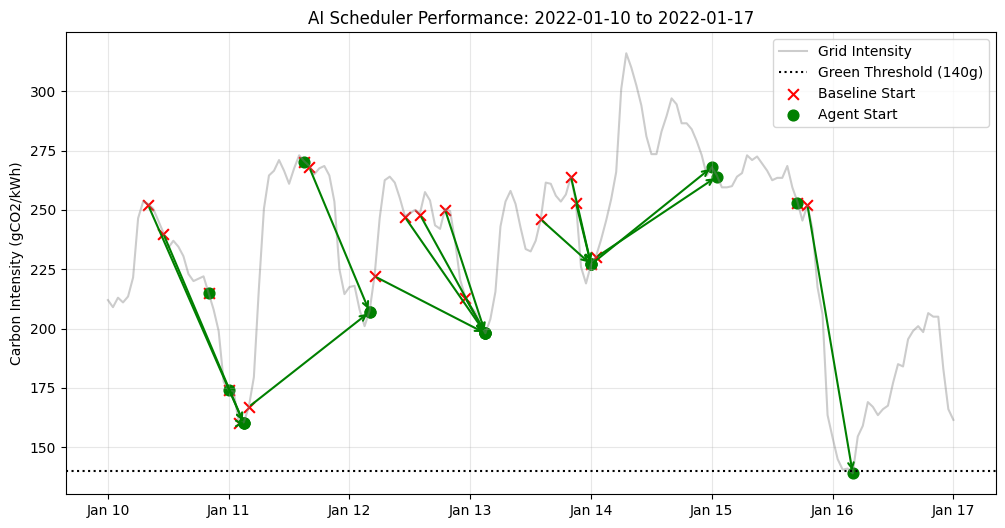

In [ ]:
# --- Run It! ---
final_df = run_custom_scenario("2022-01-10", "2022-01-17")

⚙️ Running Scenario: 2018-08-10 to 2018-09-17...
🌱 Total Baseline: 8395 gCO2 | Agent: 6811 gCO2
🚀 Carbon Reduction: 18.9%


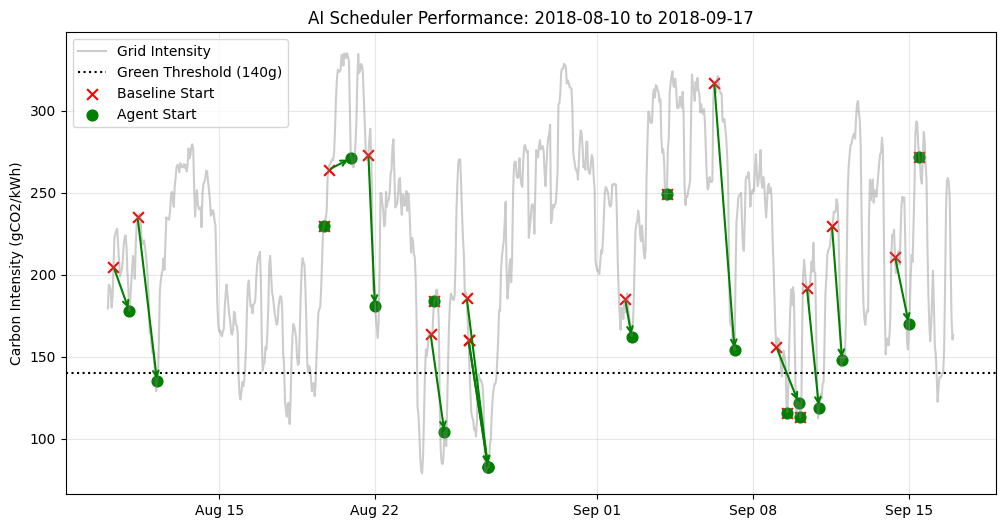

In [ ]:
# --- Run It! ---
final_df = run_custom_scenario("2018-08-10", "2018-09-17")